# Extracting temperature at specific reefs
**Author**: Denisse Fierro Arcos  

This notebook will show how to access the RIMReP `geoparquet` collection for the Regional Data by Local Government Area (LGA) from the Australian Bureau of Statistics (ABS), which contains data for the period between 2011 and 2022. This dataset includes data for the Census of Population and Housing for 2011, 2016 and 2021.

Although this dataset has information available for all Australian states and territories, we will focus on accessing data for the state of Queensland only. We will create some summary table, as well as figures and maps.

## Loading libraries

In [22]:
# Accessing S3 bucket
from pyarrow import parquet as pq
# Manipulating dataframes
import pandas as pd
import numpy as np
import copy
# Checking patterns in strings using regular expressions (regex)
import re
# Interacting with operating system
import os
# Load and manipulate geospatial data
import dask_geopandas
import geopandas as gpd
# Plotting
import matplotlib.pyplot as plt
#Color maps
from matplotlib import colormaps as cmaps
# Mapping
import cartopy.crs as ccrs
import cartopy.feature as cf

## Connecting to ABS regional dataset in RIMReP collection

In [27]:
#Connecting to metadata file
md = pq.ParquetDataset(f's3://rimrep-data-public/abs-regional-lga-2021/data.parquet')

## Inspecting the structure of the ABS dataset

In [ ]:
md.schema

DATAFLOW: string
FREQUENCY: string
TIME_PERIOD: int64
REGIONTYPE: string
REGION_CODE: int64
REGION_NAME: string
ACTIV_2: double
  -- field metadata --
  DESCRIPTION: 'Persons who have need for assistance with core activities' + 4
  UNIT: 'Percent'
  MULTIPLIER: 'None'
ACTIV_3: double
  -- field metadata --
  DESCRIPTION: 'Persons who have need for assistance with core activities'
  UNIT: 'Number'
  MULTIPLIER: 'None'
ADFS_2: double
  -- field metadata --
  DESCRIPTION: 'Currently serving in the Australian Defence Force'
  UNIT: 'Persons'
  MULTIPLIER: 'None'
ADFS_3: double
  -- field metadata --
  DESCRIPTION: 'Previously served in the Australian Defence Force'
  UNIT: 'Persons'
  MULTIPLIER: 'None'
ADFS_4: double
  -- field metadata --
  DESCRIPTION: 'Currently serving in the Australian Defence Force (%)'
  UNIT: 'Percent'
  MULTIPLIER: 'None'
ADFS_5: double
  -- field metadata --
  DESCRIPTION: 'Previously served in the Australian Defence Force (%)'
  UNIT: 'Percent'
  MULTIPLIER: 'N

We can see that there are a large number of columns available in this dataset and not all of them can be shown in the table above. We can check the exact number of columns by using the `len` function.

In [5]:
len(md.schema)

665

We have 665 columns available and as we can see above, some of the columns include a description, the units and multipliers used in the data they contain. We will extra this information and create a new dataframe with it.

In [6]:
# Creating empty lists to store metadata
col_name = []
description = []
units = []
multiplier = []

# Looping through each item in the schema
for i in md.schema:
    #Get name of column
    col_name.append(i.name)
    #If available, get the metadata
    if i.metadata is not None:
        description.append(i.metadata[b'DESCRIPTION'].decode('utf-8'))
        units.append(i.metadata[b'UNIT'].decode('utf-8'))
        multiplier.append(i.metadata[b'MULTIPLIER'].decode('utf-8'))
    #If no metadata, append NaN
    else:
        description.append(np.nan)
        units.append(np.nan)
        multiplier.append(np.nan)

# Creating dataframe from lists
da = pd.DataFrame({'col_name': col_name, 'description': description, 'units': units, 'multiplier': multiplier})
# Dropping rows with no description
da.dropna(subset = ['description'], inplace = True)
# Resetting indices
da.reset_index(drop = True, inplace = True)

# Checking results
da

,col_name,description,units,multiplier
0,ACTIV_2,Persons who have need for assistance with core...,Percent,None
1,ACTIV_3,Persons who have need for assistance with core...,Number,None
2,ADFS_2,Currently serving in the Australian Defence Force,Persons,None
3,ADFS_3,Previously served in the Australian Defence Force,Persons,None
4,ADFS_4,Currently serving in the Australian Defence Fo...,Percent,None
...,...,...,...,...
648,WORK_TRAV_5,Used one method of travel to work: Car (as dri...,Number,None
649,WORK_TRAV_6,Used one method of travel to work: Motor bike/...,Number,None
650,WORK_TRAV_7,Used one method of travel to work: Bicycle,Number,None
651,WORK_TRAV_8,Used one method of travel to work: Other,Number,None


We will not be keeping over 600 columns in our dataframe, so we will filter the columns to only keep the ones that we are interested in.  
  
For this example, we have already selected some columns of interest:  
- `ERP_23`: Median age  
- `ERP_F_(2-19)`: Number of females per age group  
- `ERP_F_20`: Estimated number of females in population  
- `ERP_M_(2-19)`: Number of males per age group  
- `ERP_M_20`: Estimated number of males in population  
- `ERP_P_20`: Estimated resident population  
- `ERP_17`: Percentage population of working age (15-64 years old)  
- `EQUIV_2`: Median household income  
    
Below, we will create a list of relevant columns that we will use to filter the ABS dataset to avoid loading all the columns into memory.

In [12]:
# In addition to the columns named above, we will also keep the time period, region code, region name and geometry columns
columns = ['TIME_PERIOD', 'REGION_CODE', 'REGION_NAME', 'ERP_17', 'ERP_23', 'ERP_P_20', 'EQUIV_2', 'geometry']

# From the reference table we created above, we will identify the columns that contain the number of females and males in the population.
# We will filter our table using the following conditions: 1. column name starts with either ERP_M_ or ERP_F_, and the units must be persons.
columns += da.col_name[((da.col_name.str.startswith('ERP_M_')) | (da.col_name.str.startswith('ERP_F'))) & (da.units == 'Persons')].tolist()

#Checking results - Last 10 rows
columns[-10:]

['ERP_M_19',
 'ERP_M_2',
 'ERP_M_20',
 'ERP_M_3',
 'ERP_M_4',
 'ERP_M_5',
 'ERP_M_6',
 'ERP_M_7',
 'ERP_M_8',
 'ERP_M_9']

If you would like to choose different columns, you can either view the table in its entirety and scroll through its contents, or you could query it as we have done above.  
  
Below, we are including another examples of how to query the reference table. We will be looking for rows that contain the word **overseas** in the `description` column. 

In [68]:
da[da.description.str.contains('overseas')]

,col_name,description,units,multiplier
6,AGEMIG_10,Persons born overseas: 40-44 years,Number,None
7,AGEMIG_11,Persons born overseas: 45-49 years,Number,None
8,AGEMIG_12,Persons born overseas: 50-54 years,Number,None
9,AGEMIG_13,Persons born overseas: 55-59 years,Number,None
10,AGEMIG_14,Persons born overseas: 60-64 years,Number,None
...,...,...,...,...
596,RELMIG_7,Persons born overseas: Religious affiliation: ...,Percent,None
597,RELMIG_9,Persons born overseas: Religious affiliation: ...,Percent,None
620,TOTMIG_2,Females born overseas,Number,None
621,TOTMIG_3,Males born overseas,Number,None


## Subsetting ABS dataset: QLD LGAs
We can see that there is a `REGION_CODE` column, which as its name suggests, it contains a code that identifies its region or LGA included in the dataset. The [ABS website](https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/non-abs-structures/local-government-areas) states that LGAs are identified by a unique five digit code. The first digit identifies the state or territory where the LGA is located and the four remaining digits identify the LGA itself. This means that we can use this column to select LGAs within Queensland only, which will reduce the size of the dataset.

According to the [LGA documentation](https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/main-structure-and-greater-capital-city-statistical-areas/australia-and-stateterritory) in the ABS website, the digit identifying the state of QLD is the number three (3). Given that LGA codes have five digits in total, we know that QLD LGAs will range between 30000 and 39999. We can now build our query to extract the data we need.

In [15]:
# Creating filter with maximum and minimum values for QLD LGAs
filter = [('REGION_CODE', '>=', 30000),
          ('REGION_CODE', '<=', 39999)]

# Connecting to the S3 bucket where the ABS census data is stored
dask_geo_df = dask_geopandas.read_parquet('s3://rimrep-data-public/abs-regional-lga-2021/data.parquet', 
                                          #Applying initial bounding box filter
                                          filters = [filter],
                                          #Specifying the column to be used as index
                                          index = 'fid',
                                          #Specifying the columns to be loaded
                                          columns = columns,
                                          #Connecting anonimously as no authentication is needed for this s3 bucket (it is public)
                                          storage_options = {"anon": True}) 

# Loading results to memory
qld_lgas_sub = dask_geo_df.compute()

#Checking results
qld_lgas_sub.head()

,TIME_PERIOD,REGION_CODE,REGION_NAME,ERP_17,ERP_23,ERP_P_20,EQUIV_2,geometry,ERP_F_10,ERP_F_11,...,ERP_M_19,ERP_M_2,ERP_M_20,ERP_M_3,ERP_M_4,ERP_M_5,ERP_M_6,ERP_M_7,ERP_M_8,ERP_M_9
fid,,,,,,,,,,,,,,,,,,,,,
209,2011,30250,Aurukun,NaN,NaN,NaN,348.0,"MULTIPOLYGON (((142.18515 -12.61154, 142.12905...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
210,2011,30300,Balonne,NaN,NaN,NaN,669.0,"POLYGON ((147.38071 -27.87950, 147.38161 -27.8...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211,2011,30370,Banana,NaN,NaN,NaN,852.0,"POLYGON ((149.78269 -24.53844, 149.77871 -24.5...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,2011,30410,Barcaldine,NaN,NaN,NaN,676.0,"POLYGON ((144.92540 -23.21909, 144.92548 -23.2...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,2011,30450,Barcoo,NaN,NaN,NaN,752.0,"POLYGON ((141.78111 -24.62401, 141.78130 -24.6...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Creating summary tables
We will use data for the most recent census (2021) to create a summary table for all LGAs in Queensland. We will include total population and population percentage by gender, median age, percentage of working population and median household income.

In [112]:
# Selecting rows with data from 2021 census
sub = qld_lgas_sub[qld_lgas_sub['TIME_PERIOD'] == 2021]
qld_2021 = copy.deepcopy(sub)
del sub

# Calculating percentage of population by gender
qld_2021['female_per'] = qld_2021.apply(lambda x: x['ERP_F_20'] / x['ERP_P_20'], axis = 1)
qld_2021['male_per'] = qld_2021.apply(lambda x: x['ERP_M_20'] / x['ERP_P_20'], axis = 1)

# Renaming columns so data can be easily identified
qld_2021 = qld_2021.rename(columns = {"ERP_P_20": "tot_population", \
    "ERP_17": "working_age_per", "EQUIV_2": "med_house_inc_AUD"})

# Selecting columns of interest
qld_2021 = qld_2021[['REGION_CODE', 'REGION_NAME', 'tot_population', 'female_per', 'male_per', \
    'working_age_per', 'med_house_inc_AUD']]

# Checking results
qld_2021


,REGION_CODE,REGION_NAME,tot_population,female_per,male_per,working_age_per,med_house_inc_AUD
fid,,,,,,,
3491,30250,Aurukun,1131.0,0.526967,0.473033,72.1,484.0
3492,30300,Balonne,4379.0,0.497145,0.502855,63.4,914.0
3493,30370,Banana,14663.0,0.483189,0.516811,62.9,1079.0
3494,30410,Barcaldine,2863.0,0.490395,0.509605,62.6,974.0
3495,30450,Barcoo,312.0,0.464744,0.535256,67.9,1220.0
...,...,...,...,...,...,...,...
3564,37340,Whitsunday,37660.0,0.482687,0.517313,66.2,955.0
3565,37400,Winton,1132.0,0.510601,0.489399,63.1,963.0
3566,37550,Woorabinda,1041.0,0.553314,0.446686,58.2,411.0


We can then save this summary table into a local machine as a csv file using the code below.

In [114]:
# Ensuring Outputs folder exists, if not create it
os.makedirs('Outputs', exist_ok = True)

#Saving results
qld_2021.to_csv('Outputs/QLD_LGA_summaries_2021.csv', index = False)

The summary table is also available to be filtered by LGA name or code or using any other conditions. For example, we will select LGAs where median house income is above $1,000, and percentage of people of working age is 75% or more.

In [116]:
qld_2021[(qld_2021.med_house_inc_AUD > 1000) & (qld_2021.working_age_per >= 75)]

,REGION_CODE,REGION_NAME,tot_population,female_per,male_per,working_age_per,med_house_inc_AUD
fid,,,,,,,
3499,31750,Bulloo,342.0,0.476608,0.523392,77.2,1157.0
3512,32750,Diamantina,270.0,0.437037,0.562963,76.3,1468.0
3533,34800,McKinlay,838.0,0.459427,0.540573,78.8,1145.0


## Plotting age classes
As part of our dataset we have information about the number of people in different age classes by gender. We can create a bar plot using this data. For this example, we will select census data from Townsville for the years 2016 and 2021.

### Extracting data for Townsville
We will also need to get information about the age ranges included in the age group columns. We will get this information from the description table. We will use the column names starting with `ERP_F`, which contain information about number of individuals for females, but the age ranges in each class is the same across all genders.

In [212]:
#Getting information about age classes - Select column names starting with ERP_F 
# except ERP_F_20 because it contains total number of people. We will also include 
# only columns with number of people and not percentages
sub = da[(da.col_name.str.contains('ERP_F_')) & (da.units == "Persons") & (da.col_name != "ERP_F_20")]
age_groups = copy.deepcopy(sub)
del sub

#Getting the age group numbers and age range for each age class
age_groups['age_group'] = age_groups.apply(lambda x: re.sub('Females aged ', '', x['description']), axis = 1)
age_groups['age_class'] = age_groups.apply(lambda x: re.search('[0-9]{1,2}', x['col_name']).group(0), axis = 1)
#Changing data type to integer
age_groups['age_class'] = age_groups.age_class.astype(int)

#Keeping relevant columns
age_groups = age_groups[['age_group', 'age_class']]

#Checking results
age_groups.head()

,age_group,age_class
206,40-44 years,10
207,45-49 years,11
208,50-54 years,12
209,55-59 years,13
210,60-64 years,14


In [258]:
#Extracting data for Townsville (2016 and 2021 only)
sub = qld_lgas_sub[(qld_lgas_sub.REGION_NAME == "Townsville") & ((qld_lgas_sub.TIME_PERIOD == 2016) | (qld_lgas_sub.TIME_PERIOD == 2021))]
#Getting names of columns with age groups that do not include percentages
sub_cols = da[((da.col_name.str.contains('ERP_F_')) | (da.col_name.str.contains('ERP_M_'))) & (da.units == "Persons") & (da.col_name != "ERP_F_20") & (da.col_name != "ERP_M_20")]

#Selecting columns of interest
sub = pd.concat([sub['TIME_PERIOD'], sub[sub_cols.col_name.tolist()]], axis = 1)
#Making a new copy that can be manipulated
townsville = copy.deepcopy(sub)
#Deleting variables not needed
del sub, sub_cols

#Checking results
townsville

,TIME_PERIOD,ERP_F_10,ERP_F_11,ERP_F_12,ERP_F_13,ERP_F_14,ERP_F_15,ERP_F_16,ERP_F_17,ERP_F_18,...,ERP_M_18,ERP_M_19,ERP_M_2,ERP_M_3,ERP_M_4,ERP_M_5,ERP_M_6,ERP_M_7,ERP_M_8,ERP_M_9
fid,,,,,,,,,,,,,,,,,,,,,
826,2016,6516.0,6483.0,6044.0,5617.0,4589.0,3946.0,2753.0,2041.0,1373.0,...,1058.0,837.0,6960.0,6720.0,6351.0,7121.0,8777.0,7710.0,6969.0,6045.0
3561,2021,6147.0,6379.0,6242.0,5963.0,5474.0,4486.0,3742.0,2587.0,1728.0,...,1421.0,936.0,6113.0,6786.0,6839.0,6557.0,8252.0,7854.0,6818.0,6605.0


In [259]:
#Rearranging data, so columns appears as rows
#Females
towns_fem = pd.concat([townsville['TIME_PERIOD'], townsville.filter(regex = 'ERP_F_.*', axis = 1)], axis = 1)
towns_fem = pd.wide_to_long(towns_fem, 'ERP_F_', i = 'TIME_PERIOD', j = 'names').reset_index()
#Renaming columns so they are easier to identify
towns_fem.rename(columns = {'ERP_F_': 'number_ind', 'names': 'age_class'}, inplace = True)
#Adding gender column
towns_fem['gender'] = 'F'

#Males - Same workflow as females
towns_mal = pd.concat([townsville['TIME_PERIOD'], townsville.filter(regex = 'ERP_M_.*', axis = 1)], axis = 1)
towns_mal = pd.wide_to_long(towns_mal, 'ERP_M_', i = 'TIME_PERIOD', j = 'names').reset_index()
towns_mal.rename(columns = {'ERP_M_': 'number_ind', 'names': 'age_class'}, inplace = True)
towns_mal['gender'] = 'M'

# # Merging dataframe into one
townsville = pd.concat([towns_fem, towns_mal], axis = 0)
# Joining with data frame containing age group information
townsville = pd.merge(townsville, age_groups, how = 'left', on = 'age_class')
#Sorting by age class
townsville = townsville.sort_values('age_class')
#Checking results
townsville

,TIME_PERIOD,age_class,number_ind,gender,age_group
57,2021,2,6113.0,M,0-4 years
21,2021,2,5481.0,F,0-4 years
20,2016,2,6403.0,F,0-4 years
56,2016,2,6960.0,M,0-4 years
23,2021,3,6231.0,F,5-9 years
...,...,...,...,...,...
17,2021,18,1728.0,F,80-84 years
55,2021,19,936.0,M,85 and over
54,2016,19,837.0,M,85 and over
19,2021,19,1605.0,F,85 and over


### Plotting time series for Townsville data

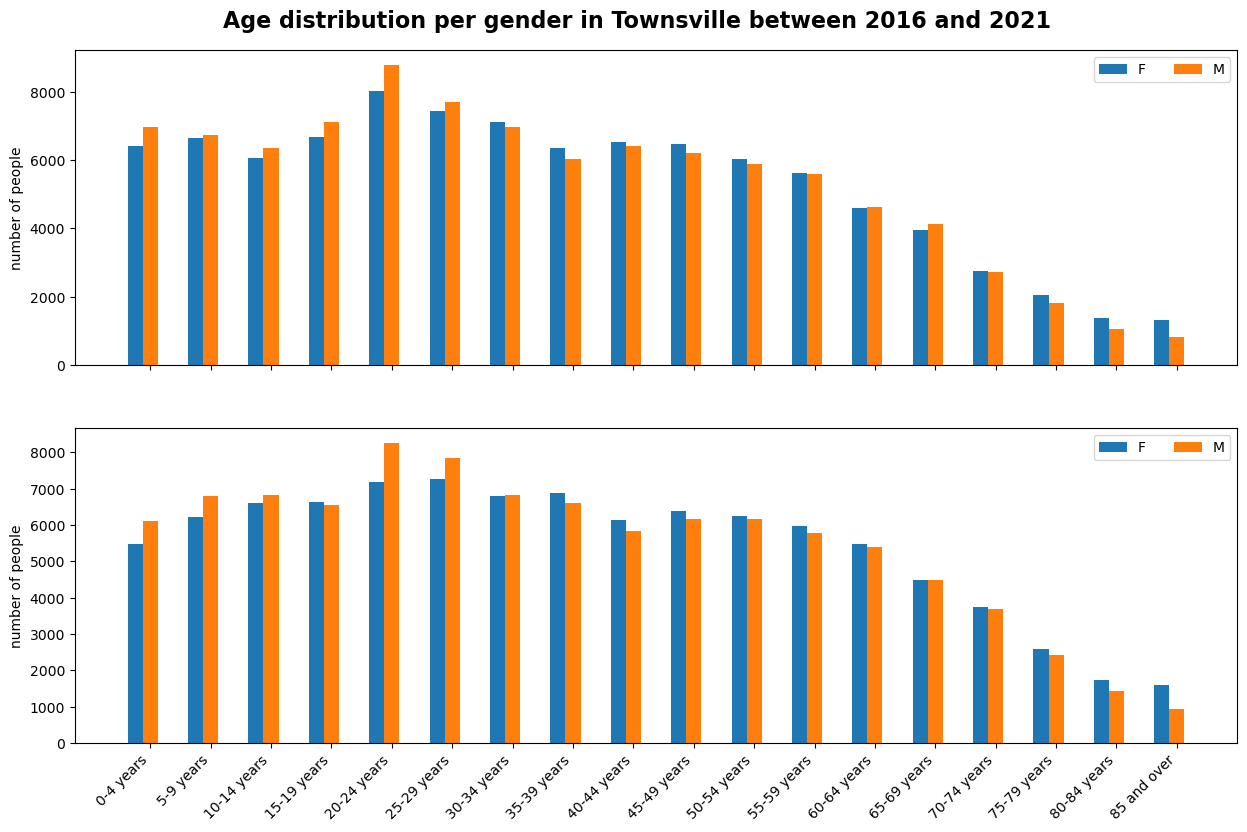

In [326]:
# We initialise the figure and axes. We also define the size of the figure.
# Axes refer to the subplots in the figure (2 rows and 1 column). They will share the x axis
fig, ax = plt.subplots(2, 1, figsize = (15, 9), sharex = True)
#Column width
width = 0.25
# Multiplier to offset bars
multiplier = 0

# Selecting data for 2016
# Group has the subset dataframes for each category
group = townsville[townsville.TIME_PERIOD == 2016].groupby('gender')
for element, g in group:
    # Plotting 2016 data in first row
    offset = width * multiplier
    ax[0].bar(g['age_class']+offset, g['number_ind'], width, label = element)
    multiplier += 1
    
# Resetting multiplier
multiplier = 0
# Selecting data for 2021
# Group has the subset dataframes for each category
group = townsville[townsville.TIME_PERIOD == 2021].groupby('gender')
for element, g in group:
    # Plotting 2016 data in first row
    offset = width * multiplier
    ax[1].bar(g['age_class']+offset, g['number_ind'], width, label = element)
    multiplier += 1

#Adding title to figure
fig.suptitle('Age distribution per gender in Townsville between 2016 and 2021', fontsize = 16, fontweight = 'bold', y = 0.925)
#Change y axis label
[i.set_ylabel('number of people') for i in ax.flat]
#Changes x axis labels
ax[1].set_xticks(g.age_class+width, g.age_group.tolist(), rotation = 45, ha = 'right');
#Adding legend
[i.legend(loc = 'upper right', ncols = 2) for i in ax.flat];

From this plot, we can see that the amount of people in the younger age classes has decreased, while there was an increase in the older classes between the 2016 and 2021 censuses.

We can save the plot in a file named `Townsville_age_classes.png` above as follows: `plt.savefig('Townsville_age_classes.png')`.

## Creating choropleth map with poulation data from the 2021 census
We will select 2021 data from the QLD data we extracted at the beginning. We will select two columns only: `ERP_P_20`, which has information about total number of inhabitants per LGA, and `geometry`, which has the coordinates for the boundaries of each LGA.

In [16]:
#Selecting population data from 2021 and keeping only relevant columns
qld_pop_2021 = qld_lgas_sub[qld_lgas_sub.TIME_PERIOD == 2021][['REGION_CODE', 'REGION_NAME', 'ERP_P_20', 'geometry']]

#Checking results
qld_pop_2021.head()

,REGION_CODE,REGION_NAME,ERP_P_20,geometry
fid,,,,
3491,30250,Aurukun,1131.0,"MULTIPOLYGON (((142.18515 -12.61154, 142.12905..."
3492,30300,Balonne,4379.0,"POLYGON ((147.38071 -27.87950, 147.38161 -27.8..."
3493,30370,Banana,14663.0,"POLYGON ((149.78269 -24.53844, 149.77871 -24.5..."
3494,30410,Barcaldine,2863.0,"POLYGON ((144.92540 -23.21909, 144.92548 -23.2..."
3495,30450,Barcoo,312.0,"POLYGON ((141.78111 -24.62401, 141.78130 -24.6..."


### Plotting choropleth map

Text(0.5, 0.925, 'Population per Local Government Area (2021)')

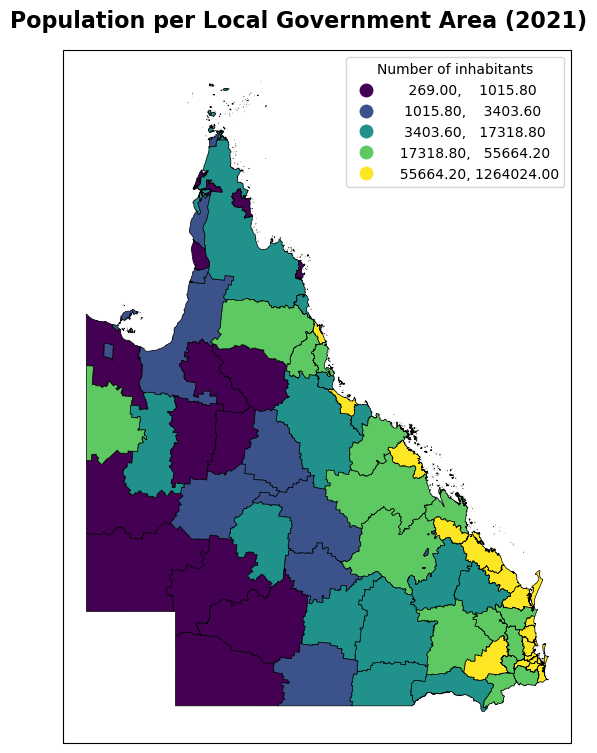

In [18]:
#Initiliasing the figure
fig = plt.figure(figsize = (15, 9))

#Adding a plot to the figure and assigning projection
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())
labels = ['1000s', '10000s', '100000s', '1000000s']

#Plottting data
qld_pop_2021.plot(column = 'ERP_P_20', ax = ax, scheme = 'quantiles', \
    cmap = 'viridis', edgecolor = 'black', linewidth = 0.5, legend = True,
    legend_kwds = {'title': 'Number of inhabitants'})

fig.suptitle('Population per Local Government Area (2021)', fontsize = 16, fontweight = 'bold', y = 0.925)
